In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
def get_pandora_data(filename):
    fp=open(filename)
    lines = fp.readlines()
    line_list = []
    lat_raw = lines[14]
    lon_raw = lines[15]
    lat = float(lat_raw.split()[-1])
    lon = float(lon_raw.split()[-1])
    del lines[0:59]
    for i in lines:
        line = i.split()
        line[7] = float(line[7])
        line[8] = float(line[8])
        if len(line[0])<=16:
            line_list.append(line)
        elif len(line[0])>16:
            line[0] = line[0][0:15]+'Z'
    for i in range(len(line_list)):
        if line_list[i][7] < 0:
            line_list[i][7] = np.NaN
        if line_list[i][7] > 1e99:
            line_list[i][7] = np.NaN
    for i in range(len(line_list)):
        if abs(line_list[i][8]) >= 1:
            line_list[i][8] = np.NaN
    line_df = DataFrame(line_list)
    line_df = line_df[[0,7,8]]
    line_df['timestamp'] = pd.to_datetime(line_df[0],format='%Y%m%dT%H%M%SZ',errors = 'coerce')
    line_df['NO2_tot_col'] = line_df[7]*2.687e16
    line_df['NO2_uncertainty'] = line_df[8]*2.687e16 ##changing the units into mol/m^2
    line_df = line_df[['timestamp','NO2_tot_col','NO2_uncertainty']]
    line_df['lon'] = lon
    line_df['lat'] = lat
    line_df = line_df.dropna()
    return line_df

In [2]:
NewHavenCT = get_pandora_data('Pandora64s1_NewHavenCT_L2Tot_rnvs1p1-7.txt')

In [3]:
import datetime
from datetime import datetime
import pytz
from datetime import datetime, timedelta, timezone
import time
import seaborn as sns

In [7]:
def time_process(city):
    city = city[(city['timestamp']>='20190101')&(city['timestamp']<='201912312359')]
    return city

In [12]:
import math
def sort_and_avg(city,tz):
    time_mask = (city['timestamp'].dt.hour >= 13+tz) & (city['timestamp'].dt.hour <= 13+tz)
    city_passby = city[time_mask]
    city_passby_group = city_passby.groupby(pd.Grouper(key='timestamp',freq='1D'))
    city_passby_avg = city_passby_group.mean()
    city_passby_size = city_passby_group.size()
    unct_sum = city_passby_group['NO2_uncertainty'].sum()
    unct_var = city_passby_group['NO2_uncertainty'].var()
    for i in range(len(city_passby_avg)):
        city_passby_avg['NO2_uncertainty'][i] = 100*(1-math.sqrt((city_passby_size[i]*unct_var[i] + (unct_sum[i]**2)/city_passby_size[i])/city_passby_size[i]**2)/city_passby_avg['NO2_tot_col'][i])
    return city_passby_avg

In [15]:
def line_plot(city):
    ax = sns.lineplot(x='timestamp', y='NO2_tot_col',ci='NO2_uncertainty',err_style = 'band',data = city)

In [8]:
NewHavenCT = time_process(NewHavenCT)

In [13]:
NewHavenCT = sort_and_avg(NewHavenCT,4)

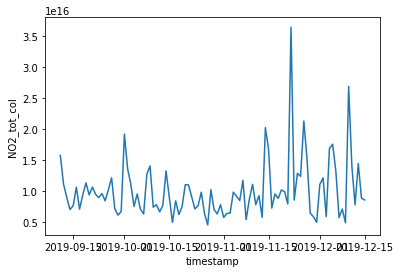

In [16]:
line_plot(NewHavenCT)

Why there is no error band?